## II-Tester différents modèles de prédiction afin de répondre au mieux à la problématique.
### II.1 Préparation des données 
 - Standardisation des données 
 - Création de l'ensemble d'entrainement et de test avec possibilité de sélectionner un % du nombre total des variables, une cible et un ensemble de variables initial
 

In [1]:
#import librairies
import math
import datetime
import time
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from scipy.stats import uniform, randint
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn import dummy
from sklearn import  metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso , ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold, StratifiedKFold
import xgboost as xgb

In [2]:
#import du nouveau fichier 
df_pred = pd.read_csv('building_selection.csv', error_bad_lines=False, sep=',')

In [3]:
#standardisation des valeurs 
def standardScaler(df):
    scaler = StandardScaler()
    scaled_features = StandardScaler().fit_transform(df.values)
    #re build scaled features dataframe on which we plot scatterss
    df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
    return df


In [4]:
#calcule le temps de training
def compute_time (start_time): 
    train_time = time.time() - start_time
    return train_time

In [5]:
#retourne les variables ayant des valeurs numériques 
def get_numerical(df) :
    numerical = []
    for y in df.columns:
        if(df[y].dtype == np.float64 or df[y].dtype == np.int64) :
            numerical.append(y)
    return numerical

In [6]:
#standadistaion des données et extraction du dataframe à utiliser lors de la prédiction
df_pred= df_pred.drop('Unnamed: 0', axis=1)
numerical = get_numerical(df_pred)
df_pred= df_pred[numerical]
df_pred= standardScaler(df_pred)
df_pred.head()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,Latitude,Longitude,ENERGYSTARScore,GHGEmissions(MetricTonsCO2e),...,Zip Codes_18388,Zip Codes_18390,Zip Codes_18792,Zip Codes_18800,Zip Codes_19575,Zip Codes_19576,Zip Codes_19578,Zip Codes_19579,Zip Codes_19582,Zip Codes_19584
0,-0.033095,0.837620,-0.358041,-0.125077,-0.088240,-0.404854,-0.093703,-0.305719,0.088330,0.123193,...,-0.313939,-0.311832,-0.171112,-0.167695,-0.224888,-0.240563,-0.22756,-0.17447,-0.196561,-0.3505
1,-0.033095,0.715303,-0.045363,-0.124710,-0.114589,-0.130450,-0.074044,-0.073403,-0.399906,0.144424,...,-0.313939,-0.311832,-0.171112,-0.167695,-0.224888,-0.240563,-0.22756,-0.17447,-0.196561,-0.3505
2,-0.033095,4.384827,-0.358041,4.589803,3.781463,1.416735,-0.068824,-0.290799,-1.550749,2.855597,...,-0.313939,-0.311832,-0.171112,-0.167695,-0.224888,-0.240563,-0.22756,-0.17447,-0.196561,-0.3505
3,-0.033095,0.592986,-0.358041,-0.271421,-0.245120,-0.404854,-0.050210,-0.236195,-2.143607,2.666897,...,-0.313939,-0.311832,-0.171112,-0.167695,-0.224888,-0.240563,-0.22756,-0.17447,-0.196561,-0.3505
4,-0.033095,1.571525,-0.099413,-0.022549,0.114333,0.833991,-0.060119,-0.452241,0.158078,0.512640,...,-0.313939,-0.311832,-0.171112,-0.167695,-0.224888,4.156922,-0.22756,-0.17447,-0.196561,-0.3505


In [7]:
df_pred.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
       'ENERGYSTARScore', 'GHGEmissions(MetricTonsCO2e)', 'BuildingAge',
       'Log-GHGEmissions(MetricTonsCO2e)', 'Log-SiteEnergyUse(kBtu)',
       'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage',
       'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage',
       'LargestUseSurfacePercentage', 'PropertyGFABuildingPercentage',
       'PrimaryPropertyType_', 'PrimaryPropertyType_Health',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18376',
       'Zip Codes_18377', 'Zip Codes_18379', 'Zip Codes_18383',
       'Zip Codes_18385', 'Zip Codes_18386', 'Zip Codes

In [8]:
#Initialisations génériques : la liste des variables target et spéciales (à intégrer au calcul par la suite)
target_columns=['ENERGYSTARScore', 'Log-GHGEmissions(MetricTonsCO2e)', 'Log-SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
#les variables à exploiter sont toutes les variables du dataframe auxquelles on élimine les variables target 
treated_columns= [ele for ele in df_pred.columns if ele not in target_columns]


In [9]:
print (df_pred['NumberofBuildings'])

0     -0.033095
1     -0.033095
2     -0.033095
3     -0.033095
4     -0.033095
         ...   
909   -0.033095
910   -0.033095
911   -0.033095
912   -0.033095
913   -0.033095
Name: NumberofBuildings, Length: 914, dtype: float64


In [10]:
#fonction qui calcule les données d'apprentissage et de test sachant les variables,
#la target, le pourcentage des variables à utiliser par rapport au total 
def get_train_test_data(df_pred, target, treated_columns, percentage) : 
    y= df_pred.loc[:,target]
    nb = percentage*len(treated_columns)/100
    other= treated_columns[: int(nb)]
    X= df_pred.loc[:,other]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    print(X_train.shape)
    print(y_test.shape)
    return X, y, X_train, X_test, y_train, y_test

In [11]:
#fonction qui rajoute les résultats rmse, r2, temps de calcul au dataframe de résultats
def add_to_results(results, model_name, rmse, r2, train_time):
    results = results.append(pd.DataFrame({
    'Modèle' : [model_name], 
    'Score_RMSE' : [rmse],
    'Score_R2' : [r2],
    'Temps d\'entrainement': [train_time]
    }), ignore_index=True)
    return results

In [12]:
#trouver automatiquement le meilleur modèle
def get_best_model(df, c):
    max_index= df[c].idxmax()
    model_name = df.at[max_index, 'Modèle']
    return model_name

## Prediction de la variable consommation
### II.2 Modèles de prédiction
 - Définition des fonctions corrépondants aux modèles de prédiction suivants : Ridge, Lasso, Forêts aléatoires, Gradient boosting, XGBoost, SVM 
 - Tests des modèles sans puis avec la variable EnergySTARScore
 - Validation croisée pour le choix des meilleurs hyperparamètres
 - Optimisation des hyperparamètres



In [13]:
#dataframe pour les résultats par defaut
results_conso = pd.DataFrame({})
#dataframe pour les meilleurs résultats après cross validation
results_conso_cross_validation = pd.DataFrame({})
#dataframe pour les résultats du meilleur modèle avec différents pourcentages de meilleurs features 
results_conso_percentages = pd.DataFrame(columns = ['Percentage', 'Score_R2', 'Score_RMSE'])

In [14]:
target = ['Log-SiteEnergyUse(kBtu)']
percentage = 100
X, y,X_train, X_test, y_train, y_test = get_train_test_data(df_pred, target, treated_columns, percentage)

(685, 41)
(229, 1)


#### Modèle naif DummyRegressor

In [15]:
def dummy_regressor(X_train, y_train, X_test, y_test):
    start_time = time.time()
    dum = dummy.DummyRegressor(strategy='mean')
    dum.fit(X_train, y_train)
    y_pred = dum.predict(X_test)
    baseline_error = np.mean((y_pred - y_test.values) ** 2)
    train_time = compute_time (start_time)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, dum.predict(X_test)))
    r2= metrics.r2_score(y_test, dum.predict(X_test))
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))
    return rmse, r2, baseline_error, train_time

In [16]:
rmse, r2, baseline_error, train_time= dummy_regressor(X_train, y_train, X_test, y_test)

RMSE : 1.0064834507553402, R2 : -0.0002806104650681096, Time :0.0029947757720947266


In [17]:
results_conso = add_to_results(results_conso, "Dummy regressor", rmse, r2, train_time)
#ajouter le résultat aux dataframe résultats

#### Régression Ridge
* pas besoin d'appel à GridSearchCV ou RandomizedSearchCV pour la validation croisée, un simple loop sur les valeurs du terme de régularisation alpha suffit

In [18]:
#définir plusieurs valeurs de alpha 
alphas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01,  0.05, 0.1, 0.5,  0.95, 1]

In [19]:
#fonction qui applique le modèle pour une valeur définie de alpha
def run_ridge_prediction(X_train, y_train, X_test, y_test, a) :    
    # Training the model and evaluating training time (on whole data set)
    #temps de début
    start_time = time.time()
    ridge= Ridge()
    ridge.set_params (alpha = a )
    #entrainement
    ridge.fit(X_train, y_train)
    #calcul temps d'entrainement
    train_time = compute_time (start_time)
    #prédiction
    y_pred = ridge.predict(X_test)
    #calcul des metriques RMSE et R2 en plus du temps d'entrainement
    rmse = np.sqrt(metrics.mean_squared_error(y_test.values, y_pred))
    r2= metrics.r2_score(y_test.values, y_pred)
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))
    coefss= ridge.coef_
    return  coefss, rmse, r2, y_pred, train_time

In [20]:
#parcours des listes des variables et examen de la valeur de R2 pour voir les variables pouvant être à l'origine d'un bruit et d'une dégradation des résultats
for l in range (2, len(treated_columns) ):
    print(treated_columns[:l])
    X, y,X_train, X_test, y_train, y_test = get_train_test_data(df_pred, target, treated_columns[:l], percentage)
    coefs= []
    errors =[]
    for a in alphas :
        coefss, rmse, r2, y_pred, train_time = run_ridge_prediction(X_train, y_train, X_test, y_test, a)
        coefs.append(coefss)
        errors.append([baseline_error, rmse])


['NumberofBuildings', 'NumberofFloors']
(685, 2)
(229, 1)
RMSE : 0.660578274081102, R2 : -0.18397057559062424, Time :0.018951416015625
RMSE : 0.6605782736319447, R2 : -0.18397057398055283, Time :0.003997325897216797
RMSE : 0.6605782691403717, R2 : -0.18397055787984096, Time :0.0019948482513427734
RMSE : 0.6605782242246521, R2 : -0.18397039687276506, Time :0.001993417739868164
RMSE : 0.6605777750686354, R2 : -0.18396878680683493, Time :0.00498509407043457
RMSE : 0.6605732836262381, R2 : -0.18395268662990327, Time :0.003989696502685547
RMSE : 0.6605533242504383, R2 : -0.18388114089779473, Time :0.0039904117584228516
RMSE : 0.6605283809768892, R2 : -0.18379173308612673, Time :0.003988742828369141
RMSE : 0.6603290724049821, R2 : -0.1830774435864615, Time :0.003988981246948242
RMSE : 0.6601053542943609, R2 : -0.18227593105083684, Time :0.0029916763305664062
RMSE : 0.6600805296109586, R2 : -0.18218700865802906, Time :0.003989219665527344
['NumberofBuildings', 'NumberofFloors', 'PropertyGFAPa

RMSE : 1.2146963297457944, R2 : 0.39331348351953777, Time :0.0029914379119873047
RMSE : 1.2146983840057644, R2 : 0.39331143149575476, Time :0.0039882659912109375
RMSE : 1.2147074717731843, R2 : 0.39330235357928767, Time :0.004986286163330078
RMSE : 1.2147187350333737, R2 : 0.3932911024339911, Time :0.003991842269897461
RMSE : 1.2148051017147143, R2 : 0.3932048251826157, Time :0.003996372222900391
RMSE : 1.2148947581280976, R2 : 0.3931152551165792, Time :0.002991914749145508
RMSE : 1.2149042567022732, R2 : 0.39310576530314223, Time :0.0019953250885009766
['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage']
(685, 11)
(229, 1)
RMSE : 1.0127469287701598, R2 : 0.17674955883732313, Time :0.003988504409790039
RMSE : 1.0127469270293339, R2 : 0.1767495616675181, Time :0.003988981246948242
RMSE : 1.

RMSE : 0.7877445715060681, R2 : 0.6172963606912256, Time :0.00399017333984375
RMSE : 0.7877608921779727, R2 : 0.617280502644182, Time :0.0029921531677246094
RMSE : 0.7880406784969124, R2 : 0.6170085960390808, Time :0.0049860477447509766
RMSE : 0.788381959105535, R2 : 0.6166767963082211, Time :0.002991914749145508
RMSE : 0.7884195287159715, R2 : 0.6166402616148329, Time :0.0029926300048828125
['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage', 'PropertyGFABuildingPercentage', 'PrimaryPropertyType_', 'PrimaryPropertyType_Health', 'PrimaryPropertyType_Hotel']
(685, 18)
(229, 1)
RMSE : 0.5089069699233031, R2 : 0.7135259654251098, Time :0.009974241256713867
RMSE : 0.5089069729523426, R2 : 0.713525962

RMSE : 0.8311273857476379, R2 : 0.6244805901713153, Time :0.003988504409790039
RMSE : 0.8313209991349191, R2 : 0.6243056132552478, Time :0.0029947757720947266
RMSE : 0.8315047351737378, R2 : 0.6241395252417267, Time :0.0039899349212646484
RMSE : 0.8322813706897363, R2 : 0.6234370808573365, Time :0.0029931068420410156
RMSE : 0.8328315758130374, R2 : 0.6229390393577525, Time :0.0029904842376708984
RMSE : 0.8328870412697845, R2 : 0.6228888141851527, Time :0.003989696502685547
['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage', 'PropertyGFABuildingPercentage', 'PrimaryPropertyType_', 'PrimaryPropertyType_Health', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other',

RMSE : 0.6001895804584884, R2 : 0.5234961699431724, Time :0.0039904117584228516
['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage', 'PropertyGFABuildingPercentage', 'PrimaryPropertyType_', 'PrimaryPropertyType_Health', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage', 'BuildingType_NonResidential', 'BuildingType_Nonresidential COS', 'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18376', 'Zip Codes_18377', 'Zip Codes_18379', 'Zip Codes_18383', 'Zip Codes_18385']
(685, 30)
(229, 1)
RMSE : 0.937623819494787, R2 : 0.4636669981074205, Time :0.00399017333984375
RMSE : 0.9376238214579843, R2 : 0.46366699586147186, Time :0.0029923915

RMSE : 0.6983322442588616, R2 : 0.7363217664261357, Time :0.005000591278076172
RMSE : 0.6984132618253367, R2 : 0.7362605812003642, Time :0.003990650177001953
['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage', 'PropertyGFABuildingPercentage', 'PrimaryPropertyType_', 'PrimaryPropertyType_Health', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage', 'BuildingType_NonResidential', 'BuildingType_Nonresidential COS', 'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18376', 'Zip Codes_18377', 'Zip Codes_18379', 'Zip Codes_18383', 'Zip Codes_18385', 'Zip Codes_18386', 'Zip Codes_18388', 'Zip Codes_18390', 'Zip Codes_18792', 'Zip Codes_18

RMSE : 0.46220442526881705, R2 : 0.7917031983239133, Time :0.0029935836791992188
RMSE : 0.46212906967783945, R2 : 0.7917711122087832, Time :0.0029921531677246094
RMSE : 0.4614508895204482, R2 : 0.7923818207338378, Time :0.002991914749145508
RMSE : 0.4595132567457348, R2 : 0.7941217380011496, Time :0.0039882659912109375
RMSE : 0.4582620703980294, R2 : 0.795241363493783, Time :0.0029921531677246094
RMSE : 0.4553594536921806, R2 : 0.7978270175356328, Time :0.0019943714141845703
RMSE : 0.4537591975737196, R2 : 0.7992455016197855, Time :0.002992391586303711
RMSE : 0.45359853481386625, R2 : 0.799387638955536, Time :0.002991199493408203
['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage', 'PropertyGFABu

In [21]:
#variables à éliminer comme ils dégradent les résultats
to_remove = [ 'PrimaryPropertyType_Health','Zip Codes_18376', 'Zip Codes_18377','Zip Codes_19576', 'Zip Codes_19578', 'Zip Codes_18800',   'Zip Codes_18390', 'Zip Codes_18385', 'Zip Codes_18379', 'Zip Codes_19579'] 

In [22]:
#mise à jour des ensemble d'entrainement et de test
treated_columns= [ele for ele in treated_columns if ele not in to_remove]
X, y,X_train, X_test, y_train, y_test = get_train_test_data(df_pred, target, treated_columns, percentage)

(685, 31)
(229, 1)


In [23]:
#validation croisée par simple loop sur alpha
for a in alphas:
    run_ridge_prediction(X_train, y_train, X_test, y_test, a)

RMSE : 0.48059301068168314, R2 : 0.7525128160241225, Time :0.005983591079711914
RMSE : 0.48059300528450727, R2 : 0.7525128215828043, Time :0.005991697311401367
RMSE : 0.48059295131278956, R2 : 0.7525128771695784, Time :0.004987239837646484
RMSE : 0.48059241159916155, R2 : 0.7525134330333195, Time :0.0049893856048583984
RMSE : 0.48058701481567134, R2 : 0.7525189912730553, Time :0.00498509407043457
RMSE : 0.48053307949297047, R2 : 0.7525745367565938, Time :0.0069806575775146484
RMSE : 0.480293909915929, R2 : 0.7528207712794662, Time :0.003990650177001953
RMSE : 0.4799960218942227, R2 : 0.7531272873355075, Time :0.003988742828369141
RMSE : 0.47768472223014574, R2 : 0.7554990696396311, Time :0.0019948482513427734
RMSE : 0.47527474476830134, R2 : 0.7579599200966456, Time :0.0029935836791992188
RMSE : 0.47501939591724374, R2 : 0.7582199299298221, Time :0.002991914749145508


#### Régression Lasso

In [24]:
#fonction qui applique le modèle Lasso pour une valeur définie de alpha
def run_lasso_prediction( X_train, y_train, X_test, y_test, a) :
    start_time = time.time()
    lasso= Lasso()
    lasso.set_params(alpha = a )
    lasso.fit(X_train, y_train)
    train_time = compute_time (start_time)
    y_pred = lasso.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test.values, y_pred))
    r2= metrics.r2_score(y_test.values, y_pred)
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))
    coefss= lasso.coef_
    return coefss, rmse, r2, y_pred, train_time

In [25]:
#validation croisée par boucle for sur alpha
for a in alphas:
    run_lasso_prediction( X_train, y_train, X_test, y_test, a) 

RMSE : 0.4805773538564937, R2 : 0.7525289411044798, Time :0.021940231323242188
RMSE : 0.4805679595968331, R2 : 0.7525386160699961, Time :0.013963699340820312
RMSE : 0.4804740636753797, R2 : 0.7526353072632201, Time :0.012965202331542969
RMSE : 0.4795397825003631, R2 : 0.7535963725879622, Time :0.018949031829833984
RMSE : 0.470373158535865, R2 : 0.7629265743071523, Time :0.007978439331054688
RMSE : 0.4377897375671147, R2 : 0.794633800212193, Time :0.005984306335449219
RMSE : 0.47807824978580055, R2 : 0.7550960528286248, Time :0.00498509407043457
RMSE : 0.530481501201718, R2 : 0.6984646030603305, Time :0.004987955093383789
RMSE : 0.8268358476902834, R2 : 0.26745145905763645, Time :0.0029935836791992188
RMSE : 0.9666323074255104, R2 : -0.0011990427213630639, Time :0.002991199493408203
RMSE : 0.9666323074255104, R2 : -0.0011990427213630639, Time :0.004987239837646484


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143.0107866989981, tolerance: 0.07000916378633049
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142.33693171523893, tolerance: 0.07000916378633049
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.64044636254744, tolerance: 0.07000916378633049
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

* **Interprétation des résultats de Ridge, Lasso**

- input : X_train, y_train, X_test, y_test
- output valeurs predites y_pred
- hyperparametre : alpha

Meilleur alpha pour ridge :10
Meilleur alpha pour Lasso :0.05 et deduction des coefficients correspondants (possbilité de déduire les variables élilminées)

*Pas besoin de grid search pour l'estimation d'hyperparamètre car nous avons un seul hyperparametre alpha qu'on peut évaluer par une simple boucle


#### Forêts aléatoires

In [26]:
def get_feature_importances(model_name, model, columns, X_train, y_train):
    if model_name == 'Gradient Boosting' or model_name == 'Random Forests': 
        importance= model.feature_importances_
        coefficients = abs(model.feature_importances_)
        gbr_feature_ranking = pd.concat((pd.DataFrame(treated_columns, columns = ['Features']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)
        ax = sns.barplot(x='Coefficient', y='Features', data=gbr_feature_ranking.head(10))
        ax.set_xlabel('Coefficient')
    elif model_name == 'XGBoost': 
        feature_important = model.get_booster().get_score(importance_type='weight')
        keys = list(feature_important.keys())
        print(keys)
        coefficients = list(feature_important.values())
        print(coefficients)
        data = pd.concat((pd.DataFrame(keys, columns = ['Features']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)
        ax = sns.barplot(x='Coefficient', y='Features', data=data.head(10))
        ax.set_xlabel('Coefficient')
    elif model_name == 'SVR': 
        estimator = SVR(kernel="linear")
        selector = RFE(estimator, n_features_to_select=10, step=1)
        selector = selector.fit(X_train, y_train)
        selector.support_
        selector.ranking_
        keys = columns 
        print(keys)
        coefficients = abs(selector.ranking_)
        print(coefficients)
        #coefficients = abs(model.feature_importances_)
        data = pd.concat((pd.DataFrame(keys, columns = ['Features']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)
        ax = sns.barplot(x='Coefficient', y='Features', data=data.head(10))
        ax.set_xlabel('Coefficient')
    

   
    

In [27]:
#exécution du modèle avec les paramètres par defaut
def run_random_forest_prediction(X_train, y_train, X_test, y_test):
    start_time = time.time()
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    train_time = compute_time (start_time)
    y_pred = rf.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2= metrics.r2_score(y_test, y_pred)
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))
    get_feature_importances('Random Forests', rf, X_train.columns, X_train, y_train)
    return  rmse, r2, y_pred, train_time

<ipython-input-27-1a9b7cb43ddd>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RMSE : 0.585587360868421, R2 : 0.6325644252225278, Time :0.47672581672668457


(0.585587360868421,
 0.6325644252225278,
 array([-3.07415854e-01, -1.99131874e-01, -3.02044597e-01, -3.58234735e-02,
        -3.04526608e-01, -2.25413821e-01, -1.64312449e-01, -3.23248393e-01,
        -3.62036260e-01, -1.28613034e-01, -1.87093555e-01, -2.30196022e-01,
         3.65591241e-01, -3.05811157e-01, -2.30359308e-01, -3.42256117e-01,
        -2.38093947e-01,  9.97673589e-02, -2.39980165e-01, -3.17844094e-01,
        -2.74478975e-01, -2.11660016e-01, -2.63723471e-01,  2.08865211e-02,
        -2.71861962e-01,  6.38496108e-01, -2.19167198e-01, -3.56529513e-01,
        -1.63675750e-01,  1.76434071e-01, -3.19735613e-01, -2.40731378e-01,
        -3.15648441e-01,  6.97412148e-01, -1.99852681e-01, -2.28823902e-01,
        -2.59991480e-01,  6.17471970e-01, -2.26120204e-01, -5.19422991e-02,
         9.59735242e-01, -1.76723815e-01, -3.19177667e-01, -2.78594349e-01,
        -2.90416350e-01, -1.56523722e-02, -3.25539774e-01, -6.19567887e-02,
        -8.83144692e-02, -1.96411267e-01, -3.37

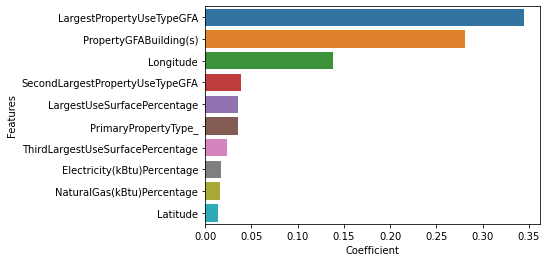

In [28]:
run_random_forest_prediction(X_train, y_train, X_test, y_test)

* **Interprétation des résultats des Forêts aléatoires**

- input : X_train, y_train, X_test, y_test
- output valeurs predites y_pred
- Validation croisée par grid search pour l'estimation d'hyperparamètre  donne : 

#### Gradient boosting

In [29]:
#exécution du modèle avec les paramètres par defaut
def run_gradient_boosting_prediction(X_train, y_train, X_test, y_test):
    start_time = time.time()
    gbr = GradientBoostingRegressor()
    gbr.fit(X_train, y_train)
    train_time = compute_time (start_time)
    y_pred = gbr.predict(X_test)
    gbr.score(X_test, y_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2= metrics.r2_score(y_test, y_pred)
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))
    get_feature_importances('Gradient Boosting', gbr, X_train.columns, X_train, y_train)
    return  rmse, r2, y_pred, train_time

RMSE : 0.558744994900404, R2 : 0.6654776763898465, Time :0.1546318531036377


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(0.558744994900404,
 0.6654776763898465,
 array([-3.48576824e-01, -2.03778585e-01, -3.15811243e-01, -1.62970362e-03,
        -2.86575550e-01, -2.53993807e-01, -1.93190829e-01, -3.32950408e-01,
        -3.59661129e-01, -1.10955189e-01, -2.27503172e-01, -2.69840699e-01,
         4.68116762e-01, -2.68261353e-01, -2.23544842e-01, -3.27758488e-01,
        -1.95410208e-01, -1.83089495e-02, -2.29461618e-01, -2.46724274e-01,
        -2.70298521e-01, -2.60499901e-01, -2.77841552e-01,  1.24709340e-02,
        -3.12095539e-01,  1.04481888e+00, -2.23835429e-01, -3.73309044e-01,
        -2.01188280e-02,  7.06925506e-02, -3.37737776e-01, -2.54432090e-01,
        -3.62639722e-01,  1.30401412e+00, -2.36833409e-01, -1.77820952e-01,
        -2.97126675e-01,  4.71765484e-01, -2.06328944e-01, -9.68111604e-02,
         8.55827203e-01, -1.82916574e-01, -3.30684058e-01, -2.77196357e-01,
        -2.97585382e-01, -1.94630554e-02, -3.02239881e-01, -1.86267257e-01,
        -4.74088472e-02, -2.01689619e-01, -3.22

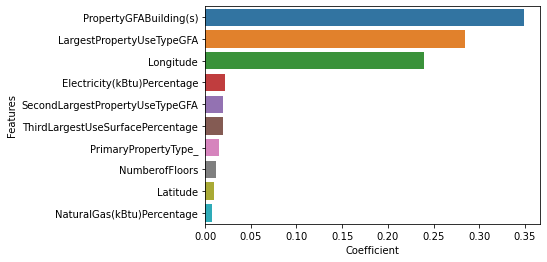

In [30]:
run_gradient_boosting_prediction(X_train, y_train, X_test, y_test)

* **Interprétation des résultats du Gradient Boosting**

- input : X_train, y_train, X_test, y_test
- output valeurs predites y_pred
- Validation croisée par grid search pour l'estimation d'hyperparamètre  donne : 


#### XGBoost

In [31]:
#exécution du modèle avec les paramètres par defaut
def run_XGBoost_prediction(X_train, y_train, X_test, y_test):
    start_time = time.time()
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X_train, y_train)
    train_time = compute_time (start_time)
    y_pred = xgb_model.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2= metrics.r2_score(y_test, y_pred)
    xgb.plot_importance(xgb_model)
    get_feature_importances('XGBoost', xgb_model, X_train.columns, X_train, y_train)
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))
    return  rmse, r2, y_pred, train_time

['PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'PropertyGFABuildingPercentage', 'PrimaryPropertyType_Other', 'LargestUseSurfacePercentage', 'PropertyGFAParking', 'Longitude', 'NumberofFloors', 'ThirdLargestUseSurfacePercentage', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'PrimaryPropertyType_', 'BuildingAge', 'PrimaryPropertyType_Storage', 'PrimaryPropertyType_Office', 'Zip Codes_18383', 'SteamUse(kBtu)Percentage', 'Zip Codes_18388', 'Zip Codes_18081', 'PrimaryPropertyType_Hotel', 'Zip Codes_17919', 'Zip Codes_19575', 'Zip Codes_19582', 'Zip Codes_18792', 'Zip Codes_19584', 'Zip Codes_18386']
[423, 235, 51, 35, 205, 145, 320, 373, 73, 196, 75, 136, 341, 6, 241, 25, 18, 10, 12, 8, 12, 8, 5, 4, 4, 1, 6, 1]
RMSE : 0.6736407043378119, R2 : 0.513755775865121, Time :0.17451214790344238


(0.6736407043378119,
 0.513755775865121,
 array([-3.41824949e-01, -2.22078592e-01, -3.16375643e-01, -5.98125644e-02,
        -2.85766214e-01, -2.36753300e-01, -2.06633016e-01, -3.61751199e-01,
        -3.75562757e-01,  4.71001631e-03, -1.90532327e-01, -3.03245425e-01,
         3.64837319e-01, -2.85018504e-01, -2.76640177e-01, -3.53668809e-01,
        -2.43539631e-01, -2.17498913e-02, -1.65865675e-01, -2.29395077e-01,
        -2.69236058e-01, -2.62082130e-01, -2.91446835e-01, -2.50745453e-02,
        -2.78824925e-01,  8.77035022e-01, -2.34685570e-01, -3.64322841e-01,
        -2.17549831e-01,  7.03395531e-02, -3.24572891e-01, -2.51877815e-01,
        -3.44980299e-01,  8.83204877e-01, -2.54553080e-01, -1.97563931e-01,
        -3.11546117e-01,  6.36296511e-01, -2.39856601e-01, -4.90624830e-02,
         7.25937545e-01, -1.57307103e-01, -3.26218843e-01, -2.95442760e-01,
        -2.98106253e-01,  9.33663100e-02, -3.55635881e-01, -1.57221451e-01,
        -1.01981116e-02, -2.43376568e-01, -3.57

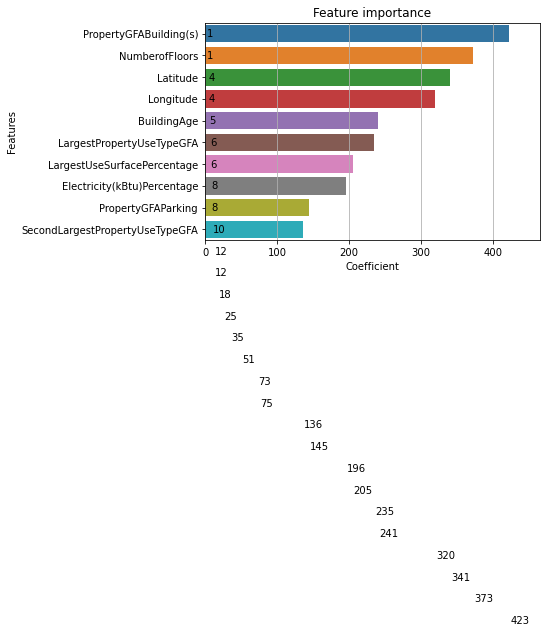

In [32]:
run_XGBoost_prediction(X_train, y_train, X_test, y_test)

* **Interprétation des résultats du XGBoost**

- input : X_train, y_train, X_test, y_test
- output valeurs predites y_pred
- Validation croisée par grid search pour l'estimation d'hyperparamètre  donne : 


#### Modèle à noyau SVR 

In [33]:
#exécution du modèle avec les paramètres par defaut
def run_svr_prediction(X_train, y_train, X_test, y_test):
    svr = SVR()
    svr.fit(X_train, y_train)
    y_pred= svr.predict(X_test)
    svr.score(X_test, y_test)
    # Evaluate
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2= metrics.r2_score(y_test, y_pred)
    get_feature_importances('SVR', svr, X_train.columns, X_train, y_train)
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))
    return  rmse, r2, y_pred, train_time

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwar

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
       'BuildingAge', 'Electricity(kBtu)Percentage',
       'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage',
       'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage',
       'PropertyGFABuildingPercentage', 'PrimaryPropertyType_',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18383',
       'Zip Codes_18386', 'Zip Codes_18388', 'Zip Codes_18792',
       'Zip Codes_19575', 'Zip Codes_19582', 'Zip Codes_19584'],
      dtype='object')
[22  1  1  1  1  1  9 18 17  1  1  1  7 21  2  4 12  1  3  1 19 20  8  6
 11 13  5 16 15 14 10]
RMSE : 0.813498773432161, R2 :

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(0.813498773432161,
 0.2908932524311145,
 array([-1.79645023e-01, -1.67797793e-01, -3.05293466e-01,  1.12513657e-01,
        -2.97926258e-01, -2.07506368e-01, -2.02617407e-01, -1.46912510e-01,
        -4.22128922e-01, -1.51349346e-01, -2.35848861e-01, -1.26460262e-01,
         1.21989453e-01, -2.48388018e-01, -2.46107899e-01, -4.07875928e-01,
        -1.46629685e-01,  2.18344211e-02, -2.50955905e-01, -8.63000254e-03,
        -2.59392743e-01, -1.75692600e-01, -2.11927584e-01, -5.85459384e-02,
        -2.86364338e-01,  6.02362680e-01, -2.16741999e-01, -2.90788176e-01,
        -1.71282787e-01,  2.00415544e-01, -3.19293364e-01, -2.61393520e-01,
        -2.87119662e-01,  5.03539699e-01, -1.87005702e-01,  1.79235290e-02,
        -2.04387068e-01,  5.67126259e-01, -1.69442933e-01, -5.88911615e-02,
         3.96778291e-01, -1.61465015e-01, -2.90887243e-01, -2.03072400e-01,
        -1.66964357e-01, -3.28064974e-03, -1.61298343e-01, -8.01862050e-02,
        -2.30517892e-01, -2.07321076e-01, -2.79

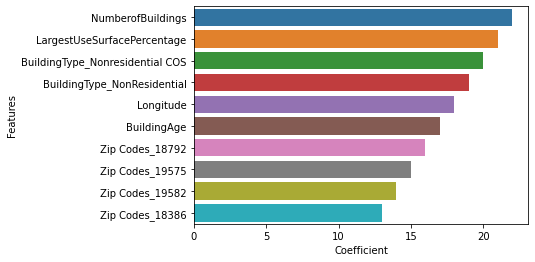

In [34]:
run_svr_prediction(X_train, y_train, X_test, y_test)

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwar

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
       'BuildingAge', 'Electricity(kBtu)Percentage',
       'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage',
       'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage',
       'PropertyGFABuildingPercentage', 'PrimaryPropertyType_',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18383',
       'Zip Codes_18386', 'Zip Codes_18388', 'Zip Codes_18792',
       'Zip Codes_19575', 'Zip Codes_19582', 'Zip Codes_19584'],
      dtype='object')
[22  1  1  1  1  1  9 18 17  1  1  1  7 21  2  4 12  1  3  1 19 20  8  6
 11 13  5 16 15 14 10]
RMSE : 0.5654769746788947, R2 

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwar

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
       'BuildingAge', 'Electricity(kBtu)Percentage',
       'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage',
       'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage',
       'PropertyGFABuildingPercentage', 'PrimaryPropertyType_',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18383',
       'Zip Codes_18386', 'Zip Codes_18388', 'Zip Codes_18792',
       'Zip Codes_19575', 'Zip Codes_19582', 'Zip Codes_19584'],
      dtype='object')
[22  1  1  1  1  1  9 18 17  1  1  1  7 21  2  4 12  1  3  1 19 20  8  6
 11 13  5 16 15 14 10]
RMSE : 0.813498773432161, R2 :

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwar

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
       'BuildingAge', 'Electricity(kBtu)Percentage',
       'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage',
       'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage',
       'PropertyGFABuildingPercentage', 'PrimaryPropertyType_',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18383',
       'Zip Codes_18386', 'Zip Codes_18388', 'Zip Codes_18792',
       'Zip Codes_19575', 'Zip Codes_19582', 'Zip Codes_19584'],
      dtype='object')
[22  1  1  1  1  1  9 18 17  1  1  1  7 21  2  4 12  1  3  1 19 20  8  6
 11 13  5 16 15 14 10]
RMSE : 3.5066562986253205, R2 

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwar

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
       'BuildingAge', 'Electricity(kBtu)Percentage',
       'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage',
       'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage',
       'PropertyGFABuildingPercentage', 'PrimaryPropertyType_',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18383',
       'Zip Codes_18386', 'Zip Codes_18388', 'Zip Codes_18792',
       'Zip Codes_19575', 'Zip Codes_19582', 'Zip Codes_19584'],
      dtype='object')
[22  1  1  1  1  1  9 18 17  1  1  1  7 21  2  4 12  1  3  1 19 20  8  6
 11 13  5 16 15 14 10]
RMSE : 0.7996451653985668, R2 

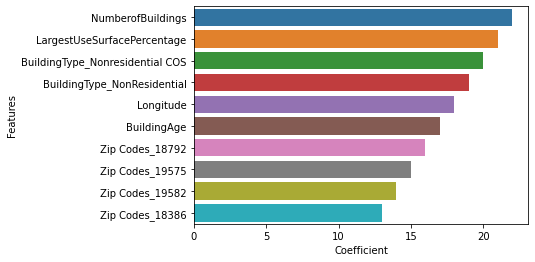

In [35]:
#varier le kernel et réexecuter 
kernels = ["linear", "rbf", "sigmoid", "poly"]
for kernel in kernels : 
    svr = SVR(kernel=kernel)
    svr.fit(X_train, y_train)
    y_pred= svr.predict(X_test)
    svr.score(X_test, y_test)
    # Evaluate
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2= metrics.r2_score(y_test, y_pred)
    get_feature_importances('SVR', svr, X_train.columns, X_train, y_train)
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))

## Validation croisée des modèles

In [36]:
#la liste des hyperparamètre à partir du nom du modèle 
def define_model_hyperparameters (model_name):
    if model_name in ['Ridge', 'Lasso']:
        hyperparameters = dict(alpha = alphas)
    elif model_name == 'Gradient Boosting' or  model_name == 'Gradient Boosting_RS' : 
        learning_rate= [0.01,0.02,0.03,0.04]
        n_estimators= [100, 150, 200]
        max_depth= [3, 5, 7, 10]
        min_samples_leaf= [5, 10, 20]
        hyperparameters = dict(learning_rate= learning_rate, n_estimators= n_estimators, max_depth= max_depth, min_samples_leaf= min_samples_leaf)
    elif model_name == 'Random Forests' or  model_name == 'Random Forests_RS' : 
        max_depth=[80, 90, 100, 110]
        max_features = [2, 3]
        min_samples_leaf =  [3, 4, 5]
        min_samples_split =  [8, 10, 12]
        n_estimators =  [100, 150, 200]
        hyperparameters = dict(max_depth= max_depth, max_features= max_features, min_samples_leaf= min_samples_leaf, min_samples_split= min_samples_split, n_estimators= n_estimators)
    elif model_name == 'XGBoost'or  model_name == 'XGBoost_RS' : 
        objective= ['reg:squarederror']
        colsample_bytree= [0.5, 0.7]
        learning_rate= [0.01, 0.1]
        max_depth= [3, 5, 7, 10]
        n_estimators= [100, 150, 200] 
        subsample= [0.5, 0.7]
        hyperparameters = dict(colsample_bytree=colsample_bytree, objective=objective, learning_rate= learning_rate, max_depth= max_depth, n_estimators= n_estimators,  subsample = subsample)
    elif model_name == 'SVR' or  model_name == 'SVR_RS' : 
        kernel = ["linear", "rbf", "sigmoid", "poly"]
        tolerance = [0.001, 0.01, 0.1, 1]
        C = [1, 1.5, 2, 2.5, 3]
        hyperparameters = dict(kernel=kernel, tol=tolerance, C=C)
        
    return hyperparameters

In [37]:
#initialisation du modèle apartir du nom
def initialize_model (model_name):
    if model_name == 'Ridge':
        model = Ridge()
    elif model_name == 'Lasso': 
        model = Lasso()
    elif model_name == 'Gradient Boosting' or  model_name == 'Gradient Boosting_RS': 
        model = GradientBoostingRegressor()
    elif model_name == 'Random Forests' or  model_name == 'Random Forests_RS': 
        model = RandomForestRegressor()
    elif model_name == 'XGBoost'or  model_name == 'XGBoost_RS': 
        model = xgb.XGBRegressor()
    elif model_name == 'SVR' or  model_name == 'SVR_RS': 
        model= SVR()
    return model

**Interprétation des hyperparamètres par modèle ** 
 - Modèles linéaires : terme de régularisation alpha 
 - Modèle Random forests :
 
 - Modèle Gradient Boosting : 
 
 - Modèle XGBoost :
 
 - Modèle SVR :

In [38]:
model_list = ['Ridge', 'Lasso', 'Gradient Boosting', 'Random Forests', 'XGBoost', 'SVR']

In [39]:
from sklearn.model_selection import KFold
print("[INFO] grid searching over the hyperparameters...")
rkFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
skFold = KFold(n_splits=5, random_state=None, shuffle=False)

[INFO] grid searching over the hyperparameters...


In [40]:
def perform_gridsearch_cross_validation_linear(kfold, model_name, results):
  #GridSearchCV : parcourir toutes les combinaisons possibles d'hyperparametres  
    print(model_name)
    hyperparameters = define_model_hyperparameters (model_name)
    print(hyperparameters)
    model= initialize_model (model_name)
    start_time = time.time()
    m=  GridSearchCV(estimator = model,  param_grid = hyperparameters, scoring = 'r2',cv=kfold, verbose=0)
    searchResults = m.fit(X_train, y_train)
    train_time = compute_time (start_time)
    bestModel = searchResults.best_estimator_   
    print ("Best model hyper parameters : {0}".format(m))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, bestModel.predict(X_test)))
    r2= metrics.r2_score(y_test, bestModel.predict(X_test))
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))
    results = add_to_results(results, model_name, rmse, r2, train_time)
    return results

In [41]:
results_conso_cross_validation= perform_gridsearch_cross_validation_linear(rkFold, 'Ridge',  results_conso_cross_validation)
results_conso_cross_validation= perform_gridsearch_cross_validation_linear(rkFold, 'Lasso',  results_conso_cross_validation)

Ridge
{'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.95, 1]}
Best model hyper parameters : GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Ridge(),
             param_grid={'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                   0.05, 0.1, 0.5, 0.95, 1]},
             scoring='r2')
RMSE : 0.47501939591724374, R2 : 0.7582199299298221, Time :2.166206121444702
Lasso
{'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.95, 1]}


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.14539367119363, tolerance: 0.06876580912868764
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.78027341154727, tolerance: 0.052022339299184685
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138.7007037872221, tolerance: 0.06701483376660983
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112.84113369192373, tolerance: 0.05416196252293669
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136.01758975028082, tolerance: 0.06918642603287556
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136.76513798479385, tolerance: 0.06814695196985143
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.17262028538364, tolerance: 0.06632325044550955
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129.07801204120724, tolerance: 0.06840116592736613
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132.7124291969431, tolerance: 0.06862361241554674
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.324757365965368, tolerance: 0.037582510478098484
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.69229842324506, tolerance: 0.06878627023381488
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.12803683303453, tolerance: 0.05252072897044018
  model = cd_fast.enet_coordinate_descent(
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

Best model hyper parameters : GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Lasso(),
             param_grid={'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                   0.05, 0.1, 0.5, 0.95, 1]},
             scoring='r2')
RMSE : 0.530481501201718, R2 : 0.6984646030603305, Time :3.33208966255188


In [42]:
#RandomizedSearchCV : parcourir quelques combinaisons d'hyperparametres de façon random  
def perform_randomsearch_cross_validation(kfold, model_name, results): 
    print(model_name)
    hyperparameters = define_model_hyperparameters (model_name)
    model= initialize_model (model_name)
    start_time = time.time()
    randomSearch = RandomizedSearchCV(estimator=model, n_jobs=-1,cv=kfold, param_distributions=hyperparameters, scoring="r2")
    searchResults = randomSearch.fit(X_train, y_train)
    train_time = compute_time (start_time)
    bestModel = searchResults.best_estimator_
    bestModel.fit(X_train, y_train)
    print ("Best model hyper parameters : {0}".format(bestModel))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, bestModel.predict(X_test)))
    r2= metrics.r2_score(y_test, bestModel.predict(X_test))
    #get_feature_importances(model_name, model, X_train.columns)
    results = add_to_results(results, model_name+"_RS", rmse, r2, train_time)
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))
    return results, bestModel

In [43]:
#dataframe pour les résultats
#results_conso_cross_validation, results_conso_percentages
results_conso_cross_validation = pd.DataFrame({})


In [44]:
results_conso_cross_validation, bestModelrf= perform_randomsearch_cross_validation(skFold, 'Random Forests',  results_conso_cross_validation)
results_conso_cross_validation, bestModelgb= perform_randomsearch_cross_validation(skFold, 'Gradient Boosting', results_conso_cross_validation)
results_conso_cross_validation ,  bestModelxgb= perform_randomsearch_cross_validation(skFold, 'XGBoost',  results_conso_cross_validation)
results_conso_cross_validation, bestModelsvr= perform_randomsearch_cross_validation(skFold, 'SVR', results_conso_cross_validation)

Random Forests


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-42-e4946b410cd9>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bestModel.fit(X_train, y_train)


Best model hyper parameters : RandomForestRegressor(max_depth=80, max_features=3, min_samples_leaf=4,
                      min_samples_split=12, n_estimators=150)
RMSE : 0.6688843668167656, R2 : 0.5205979304722578, Time :4.968766927719116
Gradient Boosting


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Best model hyper parameters : GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=5,
                          n_estimators=150)
RMSE : 0.5502888664971506, R2 : 0.6755264760607247, Time :3.4183099269866943
XGBoost
Best model hyper parameters : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)
RMSE : 0.5194817493673891, R2 : 0.7108398763629487, Time :5.140220880508423
SVR


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Best model hyper parameters : SVR(C=2.5, kernel='linear', tol=0.1)
RMSE : 0.567669571005001, R2 : 0.6547059908073779, Time :1.0093581676483154


In [45]:
results_conso_cross_validation

,Modèle,Score_RMSE,Score_R2,Temps d'entrainement
0,Random Forests_RS,0.668884,0.520598,4.968767
1,Gradient Boosting_RS,0.550289,0.675526,3.418310
2,XGBoost_RS,0.519482,0.710840,5.140221
3,SVR_RS,0.567670,0.654706,1.009358


In [46]:
def perform_gridsearch_cross_validation_m(kfold, model_name, results_conso):
  #GridSearchCV : parcourir toutes les combinaisons possibles d'hyperparametres  
    print(model_name)
    hyperparameters = define_model_hyperparameters (model_name)
    print(hyperparameters)
    model= initialize_model (model_name)
    start_time = time.time()
    gridSearch = GridSearchCV(estimator=model, param_grid=hyperparameters, n_jobs=-1,cv=kfold, scoring="r2")
    searchResults = gridSearch.fit(X_train, y_train)
    train_time = compute_time (start_time)
    bestModel = searchResults.best_estimator_
    bestModel.fit(X_train, y_train)
    #print(bestModel)
    print("Hyperparamètres du meilleur modèle ".format(bestModel))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, bestModel.predict(X_test)))
    r2= metrics.r2_score(y_test, bestModel.predict(X_test))
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))
    results_conso = add_to_results(results_conso, model_name+"_GS", rmse, r2, train_time)
    return results_conso, bestModel

### Interprétation sur le choix de modèle 

In [47]:
results_conso_cross_validation

,Modèle,Score_RMSE,Score_R2,Temps d'entrainement
0,Random Forests_RS,0.668884,0.520598,4.968767
1,Gradient Boosting_RS,0.550289,0.675526,3.418310
2,XGBoost_RS,0.519482,0.710840,5.140221
3,SVR_RS,0.567670,0.654706,1.009358


Text(0, 0.5, 'Scores')

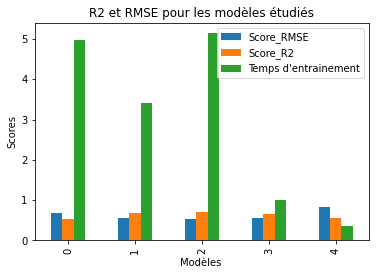

In [80]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

results_conso_cross_validation.plot(kind="bar")
plt.title('R2 et RMSE pour les modèles étudiés')
plt.xlabel("Modèles ")
plt.ylabel("Scores")

In [48]:
list_best_models = [bestModelrf, bestModelgb, bestModelxgb, bestModelsvr]

In [49]:
def best_model(best_model_name, list_best_models) :
    bestModel =""
    if best_model_name == 'Gradient Boosting' or best_model_name == 'Gradient Boosting_GS' or best_model_name == 'Gradient Boosting_RS':
        bestModel=list_best_models[1]
    elif best_model_name == 'Random Forests' or best_model_name == 'Random Forests_GS' or best_model_name == 'Random Forests_RS':
        bestModel=list_best_models[0]
    elif best_model_name == 'XGBoost' or best_model_name == 'XGBoost_GS' or best_model_name == 'XGBoost_RS': 
        bestModel=list_best_models[2]
    elif best_model_name == 'SVR' or best_model_name == 'SVR_GS' or best_model_name == 'SVR_RS':
        bestModel=list_best_models[3]
    return bestModel

In [50]:
best_model_name = get_best_model(results_conso_cross_validation, 'Score_R2')
bestModel = best_model(best_model_name,list_best_models)

In [51]:
print(best_model_name)
print(bestModel)

XGBoost_RS
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)


* **Interprétation des résultats**  
* Déduction du méilleur modèle et ranking des features selon le critère feature importance
* Reprise du traitement avec le meilleur modèle pour différents pourcentages de nombre de variables
* Reprise du pipeline entier pour la variable Emission CO2
#### Reprise du meilleur modèle avec % de features

In [52]:
target = ['Log-SiteEnergyUse(kBtu)']
percentages= [10, 30, 50, 70, 90]
def compute_r2_percentage_features(bestModel, df_pred, target, treated_columns, percentages, best_model_name, results_conso_percentages):
    for percentage in percentages :
        X, y, X_train, X_test, y_train, y_test = get_train_test_data(df_pred, target, treated_columns, percentage)  #percentage = 10 puis 30 50 70 90
        bestModel.fit(X_train, y_train)
        rmse = np.sqrt(metrics.mean_squared_error(y_test, bestModel.predict(X_test)))
        r2= metrics.r2_score(y_test, bestModel.predict(X_test))
        results_conso_percentages = results_conso_percentages.append(pd.DataFrame({
            'Percentage' : [percentage], 'Score_R2': [r2],  'Score_RMSE' : [rmse]}), ignore_index=True)
    return results_conso_percentages

In [53]:
results_conso_percentages= compute_r2_percentage_features(bestModel, df_pred, target, treated_columns,  percentages, best_model_name, results_conso_percentages)

(685, 3)
(229, 1)
(685, 9)
(229, 1)
(685, 15)
(229, 1)
(685, 21)
(229, 1)
(685, 27)
(229, 1)


In [54]:
results_conso_percentages

,Percentage,Score_R2,Score_RMSE
0,10,0.085614,0.609815
1,30,0.500543,0.353526
2,50,0.774579,0.453852
3,70,0.684860,0.588331
4,90,0.425243,1.032379


* **Interprétation des résultats** 
Avec 100% des variables les résultats sont meilleurs que 10, 50, 70, 90 % des variables 
Avec 50% des variables on a R2 proche du résultat final 

#### Intégration de EnergyStarscore dans le calcul

In [55]:
#Initialisations génériques : la liste des variables target et spéciales (à intégrer au calcul par la suite)
target_columns1=['Log-GHGEmissions(MetricTonsCO2e)', 'Log-SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
#les variables à exploiter sont toutes les variables du dataframe auxquelles on élimine les variables target 
treated_columns= [ele for ele in df_pred.columns if ele not in target_columns1]
print(treated_columns)
percentage = 100
X, y, X_train, X_test, y_train, y_test = get_train_test_data(df_pred, target, treated_columns, percentage)  


['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'ENERGYSTARScore', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage', 'PropertyGFABuildingPercentage', 'PrimaryPropertyType_', 'PrimaryPropertyType_Health', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage', 'BuildingType_NonResidential', 'BuildingType_Nonresidential COS', 'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18376', 'Zip Codes_18377', 'Zip Codes_18379', 'Zip Codes_18383', 'Zip Codes_18385', 'Zip Codes_18386', 'Zip Codes_18388', 'Zip Codes_18390', 'Zip Codes_18792', 'Zip Codes_18800', 'Zip Codes_19575', 'Zip Codes_19576', 'Zip Codes_19578', 'Zip Codes_19579', 'Zip Codes_19582', 'Zip Codes_19584']
(685, 42)
(229, 1)


In [56]:
#application du meilleur modèle 
start_time = time.time()
searchResults = bestModel.fit(X_train, y_train)
rmse = np.sqrt(metrics.mean_squared_error(y_test, bestModel.predict(X_test)))
r2= metrics.r2_score(y_test, bestModel.predict(X_test))
train_time = compute_time (start_time)     
results_conso_cross_validation = results_conso_cross_validation.append(pd.DataFrame({
            'Modèle' : [best_model_name],  'Score_RMSE' : [rmse],'Score_R2': [r2], 'Temps d\'entrainement': [train_time]}), ignore_index=True)

In [57]:
results_conso_cross_validation

,Modèle,Score_RMSE,Score_R2,Temps d'entrainement
0,Random Forests_RS,0.668884,0.520598,4.968767
1,Gradient Boosting_RS,0.550289,0.675526,3.418310
2,XGBoost_RS,0.519482,0.710840,5.140221
3,SVR_RS,0.567670,0.654706,1.009358
4,XGBoost_RS,0.820898,0.568579,0.356048


* **Interprétation des résultats** 
Le gain en ajoutant la variable EnergySTARScore est de %
Donc l'intégration de cette variable dépend du coût de l'obtention de cette variable 

In [58]:
#remove energy star score
treated_columns.remove('ENERGYSTARScore')
print(treated_columns)

['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage', 'PropertyGFABuildingPercentage', 'PrimaryPropertyType_', 'PrimaryPropertyType_Health', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage', 'BuildingType_NonResidential', 'BuildingType_Nonresidential COS', 'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18376', 'Zip Codes_18377', 'Zip Codes_18379', 'Zip Codes_18383', 'Zip Codes_18385', 'Zip Codes_18386', 'Zip Codes_18388', 'Zip Codes_18390', 'Zip Codes_18792', 'Zip Codes_18800', 'Zip Codes_19575', 'Zip Codes_19576', 'Zip Codes_19578', 'Zip Codes_19579', 'Zip Codes_19582', 'Zip Codes_19584']


In [59]:
results_conso_cross_validation, bestModelgb= perform_gridsearch_cross_validation_m(rkFold, 'Gradient Boosting', results_conso)

In [60]:
results_conso_cross_validation, bestModelxgb= perform_gridsearch_cross_validation_m(rkFold, 'XGBoost',  results_conso)

In [61]:
results_conso_cross_validation, bestModelsvr= perform_gridsearch_cross_validation_m(rkFold, 'SVR', results_conso)

In [62]:
results_conso_cross_validation, bestModelrf= perform_gridsearch_cross_validation_m(rkFold, 'Random Forests',  results_conso)

In [63]:
results_conso_cross_validation

,Modèle,Score_RMSE,Score_R2,Temps d'entrainement
0,Random Forests_RS,0.668884,0.520598,4.968767
1,Gradient Boosting_RS,0.550289,0.675526,3.418310
2,XGBoost_RS,0.519482,0.710840,5.140221
3,SVR_RS,0.567670,0.654706,1.009358
4,XGBoost_RS,0.820898,0.568579,0.356048


## Prediction de la variable emission de gaz carbonique

#### Définition de la variable target et ensemble d'apprentissage et de test

In [64]:
#dataframe pour les résultats par defaut
results_emiss = pd.DataFrame({})
#dataframe pour les meilleurs résultats après cross validation
results_emiss_cross_validation = pd.DataFrame({})
#dataframe pour les résultats du meilleur modèle avec différents pourcentages de meilleurs features 
results_emiss_percentages = pd.DataFrame(columns = ['Percentage', 'Score_R2', 'Score_RMSE'])

In [81]:
#Initialisations génériques : la liste des variables target et spéciales (à intégrer au calcul par la suite)
target_columns=['ENERGYSTARScore', 'Log-GHGEmissions(MetricTonsCO2e)', 'Log-SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
#les variables à exploiter sont toutes les variables du dataframe auxquelles on élimine les variables target 
treated_columns= [ele for ele in df_pred.columns if ele not in target_columns]


In [82]:
#get the data for training and learning
target = ['Log-GHGEmissions(MetricTonsCO2e)']
percentage = 100
X, y,X_train, X_test, y_train, y_test = get_train_test_data(df_pred, target, treated_columns, percentage)

(685, 41)
(229, 1)


#### Reprise pipeline avec la variable Emission CO2

In [84]:
#parcours des listes des variables et examen de la valeur de R2 pour voir les variables pouvant être à l'origine d'un bruit et d'une dégradation des résultats
for l in range (2, len(treated_columns) ):
    print(treated_columns[:l])
    X, y,X_train, X_test, y_train, y_test = get_train_test_data(df_pred, target, treated_columns[:l], percentage)
    coefs= []
    errors =[]
    for a in alphas :
        coefss, rmse, r2, y_pred, train_time = run_ridge_prediction(X_train, y_train, X_test, y_test, a)
        coefs.append(coefss)
        errors.append([baseline_error, rmse])


['NumberofBuildings', 'NumberofFloors']
(685, 2)
(229, 1)
RMSE : 1.1177732949949235, R2 : 0.03647831672987423, Time :0.002992868423461914
RMSE : 1.1177732950119095, R2 : 0.03647831670059021, Time :0.0020329952239990234
RMSE : 1.1177732951817692, R2 : 0.03647831640775179, Time :0.0019948482513427734
RMSE : 1.1177732968803662, R2 : 0.03647831347936692, Time :0.0020012855529785156
RMSE : 1.1177733138663257, R2 : 0.03647828419553911, Time :0.0029582977294921875
RMSE : 1.1177734837246787, R2 : 0.03647799135937635, Time :0.002959728240966797
RMSE : 1.1177742386233978, R2 : 0.036476689911835614, Time :0.00199127197265625
RMSE : 1.1177751821841355, R2 : 0.036475063209201575, Time :0.0019941329956054688
RMSE : 1.1177827281640047, R2 : 0.036462053859138366, Time :0.0029745101928710938
RMSE : 1.1177912120677178, R2 : 0.036447427413452305, Time :0.0019943714141845703
RMSE : 1.1177921543758456, R2 : 0.03644580284565546, Time :0.003017425537109375
['NumberofBuildings', 'NumberofFloors', 'PropertyGFA

RMSE : 0.7153899937180692, R2 : -1.7992878486156525, Time :0.0019943714141845703
RMSE : 0.7148240099881269, R2 : -1.794860264616433, Time :0.0019941329956054688
RMSE : 0.7142408337587685, R2 : -1.7903018525112588, Time :0.003989696502685547
RMSE : 0.7110927327372043, R2 : -1.7657588885613626, Time :0.001992940902709961
RMSE : 0.7083581685824365, R2 : -1.7445278945455378, Time :0.002994060516357422
RMSE : 0.7080742502306501, R2 : -1.742328256819512, Time :0.0029916763305664062
['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage']
(685, 13)
(229, 1)
RMSE : 1.0007851778987258, R2 : 0.5187997064765388, Time :0.004986286163330078
RMSE : 1.0007851828668275, R2 : 0.518799701698986, Time :0.0029921531677246094
RMSE : 1.0007852325445903

RMSE : 0.7366326547114521, R2 : 0.5450778336342721, Time :0.0029916763305664062
RMSE : 0.72570287983749, R2 : 0.5584774823940117, Time :0.002992391586303711
RMSE : 0.6717846811955074, R2 : 0.621648589727002, Time :0.003989696502685547
RMSE : 0.6412536882734907, R2 : 0.6552574287203841, Time :0.0039904117584228516
RMSE : 0.6388668855285053, R2 : 0.6578189771461971, Time :0.002992391586303711
RMSE : 0.6396507112511953, R2 : 0.656978818336289, Time :0.0029921531677246094
RMSE : 0.6405681338616381, R2 : 0.6559941526142319, Time :0.001995086669921875
RMSE : 0.6406591662614528, R2 : 0.655896370969006, Time :0.003988742828369141
['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage', 'PropertyGFABuildingPe

RMSE : 0.7235833362813853, R2 : 0.6685499630674613, Time :0.0019943714141845703
RMSE : 0.7224644429774448, R2 : 0.6695742279333539, Time :0.003989696502685547
RMSE : 0.7213136022015711, R2 : 0.6706260847670739, Time :0.00399017333984375
RMSE : 0.7218592049941841, R2 : 0.6701276183777665, Time :0.003989219665527344
RMSE : 0.7219341603115652, R2 : 0.6700591092485542, Time :0.005027294158935547
['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage', 'PropertyGFABuildingPercentage', 'PrimaryPropertyType_', 'PrimaryPropertyType_Health', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage', 'BuildingType_NonResidential', 'BuildingType_Nonres

RMSE : 0.7071308110077722, R2 : 0.41536594453856945, Time :0.003989458084106445
RMSE : 0.7066690268610658, R2 : 0.4161292731397007, Time :0.0029916763305664062
RMSE : 0.7055955103133495, R2 : 0.41790186759118264, Time :0.0039899349212646484
RMSE : 0.7055451843169588, R2 : 0.4179848999330098, Time :0.0029914379119873047
RMSE : 0.7055579032917693, R2 : 0.4179639155870435, Time :0.002992868423461914
['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage', 'PropertyGFABuildingPercentage', 'PrimaryPropertyType_', 'PrimaryPropertyType_Health', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage', 'BuildingType_NonResidential', 'BuildingType_N

RMSE : 0.39242412834503687, R2 : 0.0361601218966805, Time :0.0029921531677246094
['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage', 'PropertyGFABuildingPercentage', 'PrimaryPropertyType_', 'PrimaryPropertyType_Health', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage', 'BuildingType_NonResidential', 'BuildingType_Nonresidential COS', 'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18376', 'Zip Codes_18377', 'Zip Codes_18379', 'Zip Codes_18383', 'Zip Codes_18385', 'Zip Codes_18386', 'Zip Codes_18388', 'Zip Codes_18390', 'Zip Codes_18792', 'Zip Codes_18800', 'Zip Codes_19575', 'Zip Codes_19576', 'Zip Codes_19578']
(685, 38)
(229

In [85]:
to_remove= ['SteamUse(kBtu)Percentage','Zip Codes_18390', 'Zip Codes_19582', 'Zip Codes_19579', 'Zip Codes_19578', 'Zip Codes_19576', 'Zip Codes_19575', 'Zip Codes_18388', 'Zip Codes_18376','Zip Codes_18379',  'PropertyGFABuildingPercentage', 'PrimaryPropertyType_', 'PrimaryPropertyType_Other',  'PrimaryPropertyType_Hotel']

In [86]:
#mise à jour des ensemble d'entrainement et de test
treated_columns= [ele for ele in treated_columns if ele not in to_remove]
X, y,X_train, X_test, y_train, y_test = get_train_test_data(df_pred, target, treated_columns, percentage)

(685, 27)
(229, 1)


In [87]:
#pipeline des traitements repris pour la variable Emission
#dataframe pour les résultats
results_emiss = pd.DataFrame({})
rmse, r2, baseline_error, train_time= dummy_regressor(X_train, y_train, X_test, y_test)
results_emiss = add_to_results(results_emiss, "Dummy regressor", rmse, r2, train_time)
print("Modèle Ridge")
for a in alphas:
    run_ridge_prediction(X_train, y_train, X_test, y_test, a)
print("Modèle Lasso")
for a in alphas:
    run_lasso_prediction( X_train, y_train, X_test, y_test, a) 


RMSE : 0.5480518887364235, R2 : -0.015930734399571156, Time :0.0019948482513427734
Modèle Ridge
RMSE : 0.5645725281891231, R2 : -0.07810292662755214, Time :0.002991914749145508
RMSE : 0.5645725262522244, R2 : -0.07810291923018209, Time :0.0039882659912109375
RMSE : 0.5645725068832497, R2 : -0.07810284525652267, Time :0.002992391586303711
RMSE : 0.5645723131942972, R2 : -0.07810210552310504, Time :0.002991914749145508
RMSE : 0.5645703763841583, R2 : -0.07809470850607703, Time :0.003988742828369141
RMSE : 0.5645510162181004, R2 : -0.07802077003681118, Time :0.0029916763305664062
RMSE : 0.5644651451947728, R2 : -0.0776928503137162, Time :0.0019953250885009766
RMSE : 0.5643582044561357, R2 : -0.07728454041843635, Time :0.002992868423461914
RMSE : 0.5635182493599495, R2 : -0.07408020226411693, Time :0.0029916763305664062
RMSE : 0.5626050779707951, R2 : -0.0706019666922364, Time :0.0029916763305664062
RMSE : 0.5625056096022619, R2 : -0.07022343609819348, Time :0.0029921531677246094
Modèle La

<ipython-input-27-1a9b7cb43ddd>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RMSE : 0.6907155081579115, R2 : -0.6136864619107387, Time :0.43379878997802734
RMSE : 1.02652016586325, R2 : -2.564147857739602, Time :0.14063310623168945


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


['SecondLargestPropertyUseTypeGFA', 'LargestPropertyUseTypeGFA', 'Electricity(kBtu)Percentage', 'NumberofFloors', 'ThirdLargestUseSurfacePercentage', 'Latitude', 'PropertyGFABuilding(s)', 'NaturalGas(kBtu)Percentage', 'PropertyGFAParking', 'BuildingAge', 'PrimaryPropertyType_Storage', 'PrimaryPropertyType_Office', 'LargestUseSurfacePercentage', 'PrimaryPropertyType_Health', 'Longitude', 'Zip Codes_18081', 'Zip Codes_18377', 'BuildingType_NonResidential', 'Zip Codes_18383', 'Zip Codes_17919', 'Zip Codes_19584', 'Zip Codes_18800', 'Zip Codes_18792', 'Zip Codes_18385', 'NumberofBuildings']
[152, 223, 284, 366, 60, 276, 406, 97, 121, 212, 30, 25, 137, 9, 291, 10, 6, 3, 6, 2, 3, 1, 4, 2, 2]
RMSE : 1.0863308967188627, R2 : -2.991581532947898, Time :0.16057038307189941


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwar

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
       'BuildingAge', 'Electricity(kBtu)Percentage',
       'NaturalGas(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage',
       'LargestUseSurfacePercentage', 'PrimaryPropertyType_Health',
       'PrimaryPropertyType_Office', 'PrimaryPropertyType_Storage',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18377',
       'Zip Codes_18383', 'Zip Codes_18385', 'Zip Codes_18386',
       'Zip Codes_18792', 'Zip Codes_18800', 'Zip Codes_19584'],
      dtype='object')
[18  1  1  1  1  1 12  8  1  1  1  7 14  6  1  1  4 13 16  5  9 10  3 17
  2 11 15]
RMSE : 0.3888361124443041, R2 : 0.4886080041549167, Time :0.0019948482513427734


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwar

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
       'BuildingAge', 'Electricity(kBtu)Percentage',
       'NaturalGas(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage',
       'LargestUseSurfacePercentage', 'PrimaryPropertyType_Health',
       'PrimaryPropertyType_Office', 'PrimaryPropertyType_Storage',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18377',
       'Zip Codes_18383', 'Zip Codes_18385', 'Zip Codes_18386',
       'Zip Codes_18792', 'Zip Codes_18800', 'Zip Codes_19584'],
      dtype='object')
[18  1  1  1  1  1 12  8  1  1  1  7 14  6  1  1  4 13 16  5  9 10  3 17
  2 11 15]
RMSE : 0.45735187459841964, R2 : 0.29250778001380395, Time :0.0019948482513427734


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwar

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
       'BuildingAge', 'Electricity(kBtu)Percentage',
       'NaturalGas(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage',
       'LargestUseSurfacePercentage', 'PrimaryPropertyType_Health',
       'PrimaryPropertyType_Office', 'PrimaryPropertyType_Storage',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18377',
       'Zip Codes_18383', 'Zip Codes_18385', 'Zip Codes_18386',
       'Zip Codes_18792', 'Zip Codes_18800', 'Zip Codes_19584'],
      dtype='object')
[18  1  1  1  1  1 12  8  1  1  1  7 14  6  1  1  4 13 16  5  9 10  3 17
  2 11 15]
RMSE : 0.3888361124443041, R2 : 0.4886080041549167, Time :0.0019948482513427734


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwar

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
       'BuildingAge', 'Electricity(kBtu)Percentage',
       'NaturalGas(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage',
       'LargestUseSurfacePercentage', 'PrimaryPropertyType_Health',
       'PrimaryPropertyType_Office', 'PrimaryPropertyType_Storage',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18377',
       'Zip Codes_18383', 'Zip Codes_18385', 'Zip Codes_18386',
       'Zip Codes_18792', 'Zip Codes_18800', 'Zip Codes_19584'],
      dtype='object')
[18  1  1  1  1  1 12  8  1  1  1  7 14  6  1  1  4 13 16  5  9 10  3 17
  2 11 15]
RMSE : 5.741972944013638, R2 : -110.5175000379698, Time :0.0019948482513427734


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwar

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
       'BuildingAge', 'Electricity(kBtu)Percentage',
       'NaturalGas(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage',
       'LargestUseSurfacePercentage', 'PrimaryPropertyType_Health',
       'PrimaryPropertyType_Office', 'PrimaryPropertyType_Storage',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18377',
       'Zip Codes_18383', 'Zip Codes_18385', 'Zip Codes_18386',
       'Zip Codes_18792', 'Zip Codes_18800', 'Zip Codes_19584'],
      dtype='object')
[18  1  1  1  1  1 12  8  1  1  1  7 14  6  1  1  4 13 16  5  9 10  3 17
  2 11 15]
RMSE : 0.44963760535366404, R2 : 0.31617339440439174, Time :0.0019948482513427734


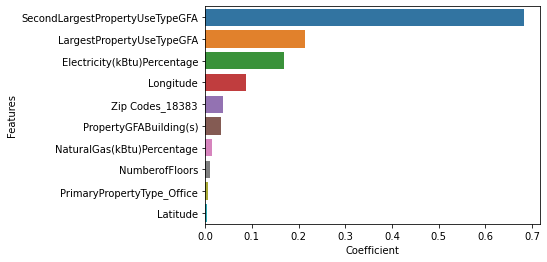

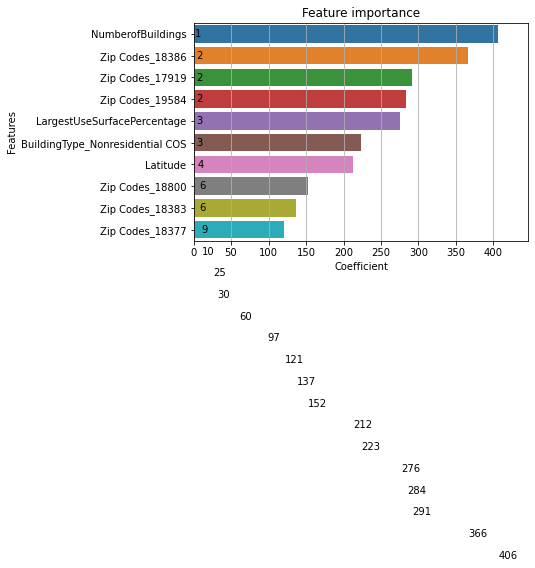

In [88]:
    
run_random_forest_prediction(X_train, y_train, X_test, y_test)
run_gradient_boosting_prediction(X_train, y_train, X_test, y_test)
run_XGBoost_prediction(X_train, y_train, X_test, y_test)
run_svr_prediction(X_train, y_train, X_test, y_test)
#varier le kernel et réexecuter 
for kernel in kernels : 
    svr = SVR(kernel=kernel)
    svr.fit(X_train, y_train)
    y_pred= svr.predict(X_test)
    svr.score(X_test, y_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2= metrics.r2_score(y_test, y_pred)
    get_feature_importances('SVR', svr, X_train.columns, X_train, y_train)
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))

In [89]:

#validation croisée lasso ridge
#results_emiss_cross_validation  = perform_gridsearch_cross_validation_linear(rkFold, 'Ridge',  results_emiss_cross_validation)
#results_emiss_cross_validation = perform_gridsearch_cross_validation_linear(rkFold, 'Lasso',  results_emiss_cross_validation)

#randomized search cross validation
#dataframe pour les résultats
results_emiss_cross_validation, bestModelrf= perform_randomsearch_cross_validation(skFold, 'Random Forests',  results_emiss_cross_validation)
results_emiss_cross_validation, bestModelgb= perform_randomsearch_cross_validation(skFold, 'Gradient Boosting', results_emiss_cross_validation)
results_emiss_cross_validation, bestModelxgb= perform_randomsearch_cross_validation(skFold, 'XGBoost',  results_emiss_cross_validation)
results_emiss_cross_validation, bestModelsvr= perform_randomsearch_cross_validation(skFold, 'SVR', results_emiss_cross_validation)
list_best_models = [bestModelrf, bestModelgb, bestModelxgb, bestModelsvr]

Random Forests


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-42-e4946b410cd9>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bestModel.fit(X_train, y_train)


Best model hyper parameters : RandomForestRegressor(max_depth=110, max_features=3, min_samples_leaf=3,
                      min_samples_split=12, n_estimators=200)


AttributeError: 'tuple' object has no attribute 'append'

In [ ]:
results_emiss_cross_validation

In [ ]:
best_model_name = get_best_model(results_emiss_cross_validation, 'Score_R2')
print(best_model_name)
bestModel = best_model(best_model_name, list_best_models)
print(bestModel)

In [ ]:

#reprendre le meilleur modèle avec les différents pourcentages de données 
results_emiss_percentages= compute_r2_percentage_features(bestModel, df_pred, target, treated_columns,  percentages, best_model_name, results_emiss_percentages)


In [72]:
results_emiss_percentages

,Percentage,Score_R2,Score_RMSE
0,10,-38.624943,2.424819
1,30,0.559528,0.812816
2,50,0.789396,0.389455
3,70,0.705317,0.473857
4,90,0.640697,0.879799


In [73]:

target_columns1=['Log-GHGEmissions(MetricTonsCO2e)', 'Log-SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
#les variables à exploiter sont toutes les variables du dataframe auxquelles on élimine les variables target 
treated_columns= [ele for ele in df_pred.columns if ele not in target_columns1]
print(treated_columns)


['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'ENERGYSTARScore', 'BuildingAge', 'Electricity(kBtu)Percentage', 'NaturalGas(kBtu)Percentage', 'SteamUse(kBtu)Percentage', 'ThirdLargestUseSurfacePercentage', 'LargestUseSurfacePercentage', 'PropertyGFABuildingPercentage', 'PrimaryPropertyType_', 'PrimaryPropertyType_Health', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Storage', 'BuildingType_NonResidential', 'BuildingType_Nonresidential COS', 'Zip Codes_17919', 'Zip Codes_18081', 'Zip Codes_18376', 'Zip Codes_18377', 'Zip Codes_18379', 'Zip Codes_18383', 'Zip Codes_18385', 'Zip Codes_18386', 'Zip Codes_18388', 'Zip Codes_18390', 'Zip Codes_18792', 'Zip Codes_18800', 'Zip Codes_19575', 'Zip Codes_19576', 'Zip Codes_19578', 'Zip Codes_19579', 'Zip Codes_19582', 'Zip Codes_19584']


In [74]:

percentage = 100
X, y, X_train, X_test, y_train, y_test = get_train_test_data(df_pred, target, treated_columns, percentage)  
#application du meilleur modèle 
results_emiss_cross_validation= perform_randomsearch_cross_validation(skFold, best_model_name,  results_emiss_cross_validation)   

(685, 42)
(229, 1)
SVR_RS
Best model hyper parameters : SVR(C=1, kernel='poly', tol=0.1)
RMSE : 0.5396783327825387, R2 : 0.7861267845515822, Time :1.1259877681732178


C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [75]:
results_emiss_cross_validation

(                 Modèle  Score_RMSE  Score_R2  Temps d'entrainement
 0                 Ridge    0.860129  0.610020              2.270971
 1                 Lasso    1.380547 -0.004657              4.553821
 2     Random Forests_RS    1.183987  0.261060              2.585132
 3  Gradient Boosting_RS    1.244421  0.183700              3.836763
 4            XGBoost_RS    1.184341  0.260618              5.610942
 5                SVR_RS    0.820676  0.644975              1.030298
 6             SVR_RS_RS    0.539678  0.786127              1.125988,
 SVR(C=1, kernel='poly', tol=0.1))

In [76]:
#grid search cross validation
results_emiss_cross_validation, bestModelrfg= perform_gridsearch_cross_validation_m(rkFold, 'Gradient Boosting', results_emiss_cross_validation)
results_emiss_cross_validation, bestModelgbg= perform_gridsearch_cross_validation_m(rkFold, 'XGBoost', results_emiss_cross_validation)
results_emiss_cross_validation, bestModelxgbg= perform_gridsearch_cross_validation_m(rkFold, 'SVR', results_emiss_cross_validation)
results_emiss_cross_validation, bestModelsvrg= perform_gridsearch_cross_validation_m(rkFold, 'Random Forests', results_emiss_cross_validation)
